# Analysis of the SSVEP data

Let's load a couple libraries we'll use repeatedly, and set the default plot size.

In [1]:
library(dplyr, warn.conflicts=FALSE)
library(stringr)
library(ggplot2)

options(repr.plot.width=10, repr.plot.height=4, repr.plot.res=300)

# Setup / preprocessing

The dataframe we're about to load has already undergone fourier transform & projection to FSAverage cortical space, so we're dealing with vertex numbers and frequency bin amplitudes, across subject and pre/post intervention measurement times.  This assumes it's in the same folder as the notebook; adjust path as needed:

**NOTE:** at the end of this section, we save out the munged data, so you can skip these cells on later runs.

## Path management

In [2]:
file.path("..", "..", "params") -> param_dir
yaml::read_yaml(file.path(param_dir, "paths.yaml")) -> paths
paths$results_dir -> results_dir
"/data/prek/results" -> results_dir  # for running on agelaius
file.path(results_dir, "pskt", "group-level", "dataframe") -> dataframe_dir

## Load the cohort groupings and inverse parameters

In [3]:
# load intervention groups
file.path(param_dir, "intervention_cohorts.yaml") -> intervention_file
yaml::read_yaml(intervention_file) -> intervention

# load pre-test cohorts
file.path(param_dir, "letter_knowledge_cohorts.yaml") -> pretest_file
yaml::read_yaml(pretest_file) -> pretest

# load inverse constraint parameters
file.path(param_dir, "inverse_params.yaml") -> inv_constraint_file
yaml::read_yaml(inv_constraint_file) -> inv
str_c(inv$orientation_constraint, "-", inv$estimate_type) -> inv_constr

## Load and clean the brain data

In [4]:
str_c("all_subjects-fsaverage-", inv_constr, "-freq_domain-stc.csv") -> fname
file.path(dataframe_dir, fname) -> fpath
readr::cols(freq="d", value="d", .default="c") -> col_types

proc.time() -> start
readr::read_csv(fpath, col_types=col_types) -> all_data
print(proc.time() - start)

   user  system elapsed 
168.404   2.263 170.677 


Now to merge in the cohort groupings and do some light cleaning:

In [5]:
proc.time() -> start
all_data %>%
    tidyr::separate(source, c("hemi", "vertex"), sep="_") %>%
    rename(amplitude=value) %>%
    mutate(hemi=str_to_lower(hemi),
           vertex=as.integer(vertex),
           subj_num=str_sub(subject, -4),
           intervention=if_else(subj_num %in% intervention$LetterIntervention, "letter", "language"),
           pretest=if_else(subj_num %in% pretest$LowerKnowledge, "lower", "upper")) %>%
    # set column order
    select(subject, pretest, intervention, timepoint, freq, hemi, vertex, amplitude, -subj_num) ->
    all_data
print(proc.time() - start)

print(all_data)

   user  system elapsed 
210.157  10.447 220.623 
# A tibble: 247,774,464 x 8
   subject   pretest intervention timepoint  freq hemi  vertex amplitude
   <chr>     <chr>   <chr>        <chr>     <dbl> <chr>  <int>     <dbl>
 1 prek_1103 lower   language     pre           0 lh         0      81.3
 2 prek_1103 lower   language     pre           0 lh         1      31.5
 3 prek_1103 lower   language     pre           0 lh         2      44.5
 4 prek_1103 lower   language     pre           0 lh         3     134. 
 5 prek_1103 lower   language     pre           0 lh         4      56.6
 6 prek_1103 lower   language     pre           0 lh         5      29.5
 7 prek_1103 lower   language     pre           0 lh         6      60.8
 8 prek_1103 lower   language     pre           0 lh         7      75.8
 9 prek_1103 lower   language     pre           0 lh         8      69.2
10 prek_1103 lower   language     pre           0 lh         9      87.9
# … with 247,774,454 more rows


## Compute noise and SNR

Next we'll define a function that will compute noise (the mean of the two frequency bins below and two frequency bins above the current bin), and apply it within a `group_by` operation.

In [6]:
# function to compute noise (mean of 2 bins above and below; handles edges gracefully)
compute_noise <- function(x) {
    rowMeans(cbind(lag(x, 2), lag(x, 1), lead(x, 1), lead(x, 2)), na.rm=TRUE)
}

proc.time() -> start

all_data %>%
    group_by(subject, timepoint, hemi, vertex) %>%
    mutate(noise=compute_noise(amplitude),
           snr=amplitude/noise) %>%
    ungroup() ->
    all_data

print(proc.time() - start)

   user  system elapsed 
203.922   1.732 205.712 


### Plot the frequency spectrum

Let's take a look at the average power spectrum across all vertices and subjects. The target frequencies are 2 Hz and 6 Hz, but we'll also highlight harmonics at 4, 12, and 18 Hz.

In [7]:
all_data %>%
    group_by(timepoint, freq) %>%
    summarise_at(c("amplitude", "snr"), mean) %>%
    mutate(target_freq=freq %in% c(2, 4, 6, 12, 18)) ->
    spectrum

print(spectrum)

# A tibble: 252 x 5
# Groups:   timepoint [2]
   timepoint  freq amplitude   snr target_freq
   <chr>     <dbl>     <dbl> <dbl> <lgl>      
 1 post        0       306.  1.11  FALSE      
 2 post        0.2      99.2 1.31  FALSE      
 3 post        0.4     107.  1.21  FALSE      
 4 post        0.6      62.3 0.980 FALSE      
 5 post        0.8      56.8 0.984 FALSE      
 6 post        1        61.6 1.15  FALSE      
 7 post        1.2      50.4 1.03  FALSE      
 8 post        1.4      45.2 1.03  FALSE      
 9 post        1.6      40.4 1.01  FALSE      
10 post        1.8      35.9 1.00  FALSE      
# … with 242 more rows


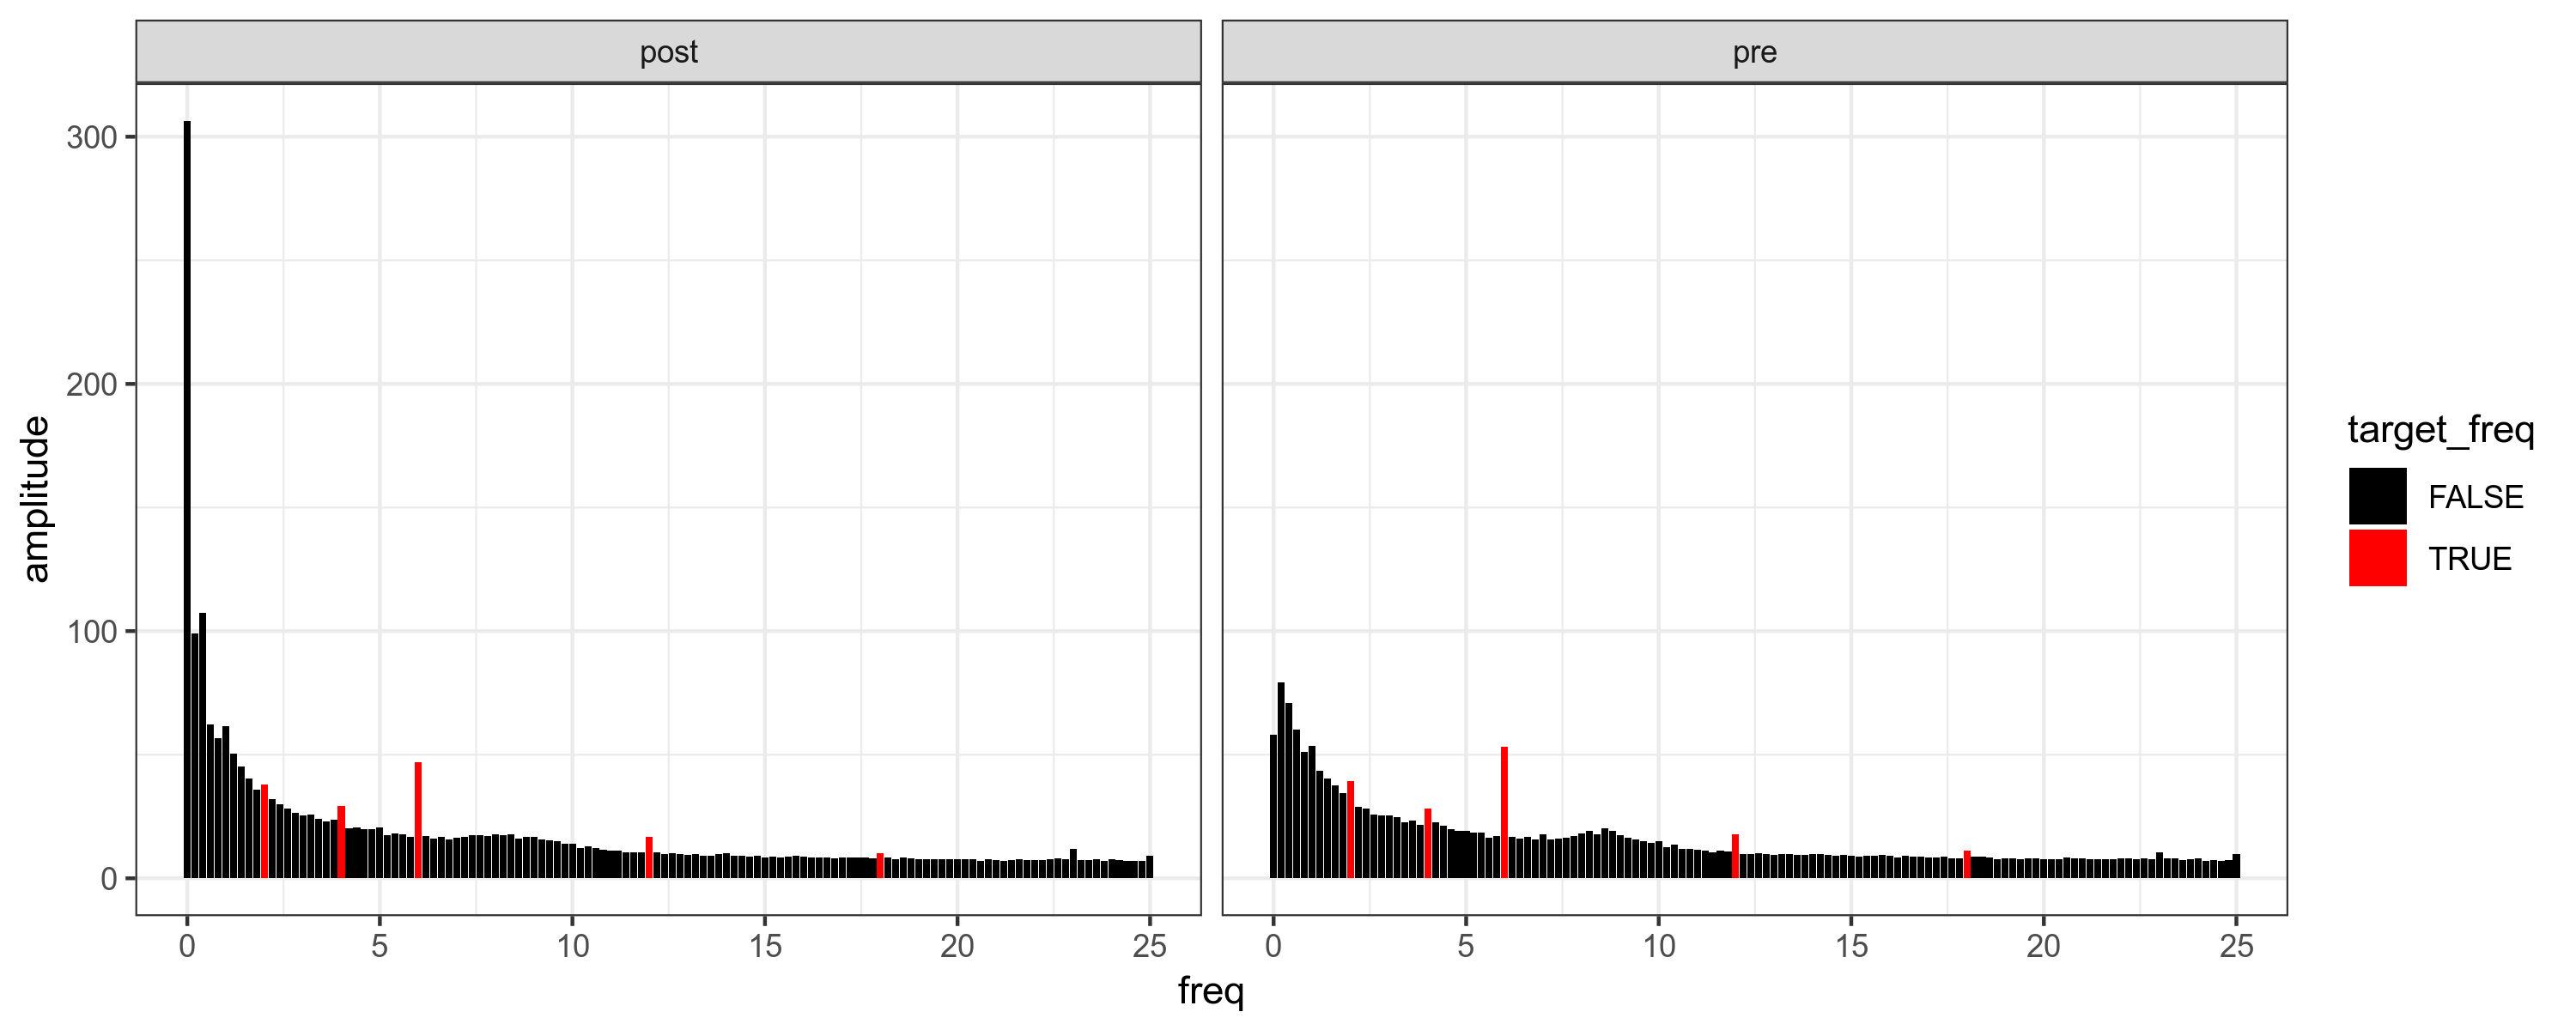

In [8]:
spectrum %>%
    ggplot(aes(x=freq, y=amplitude, fill=target_freq)) +
    facet_grid(. ~ timepoint) +
    geom_bar(stat="identity") +
    scale_fill_manual(values=c("black", "red")) +
    theme_bw()

OK, typical $\frac{1}{f}$ shape, with our target frequencies (and their harmonics) poking out. Let's flatten out the spectrum by looking at SNR instead of raw amplitude in each bin:

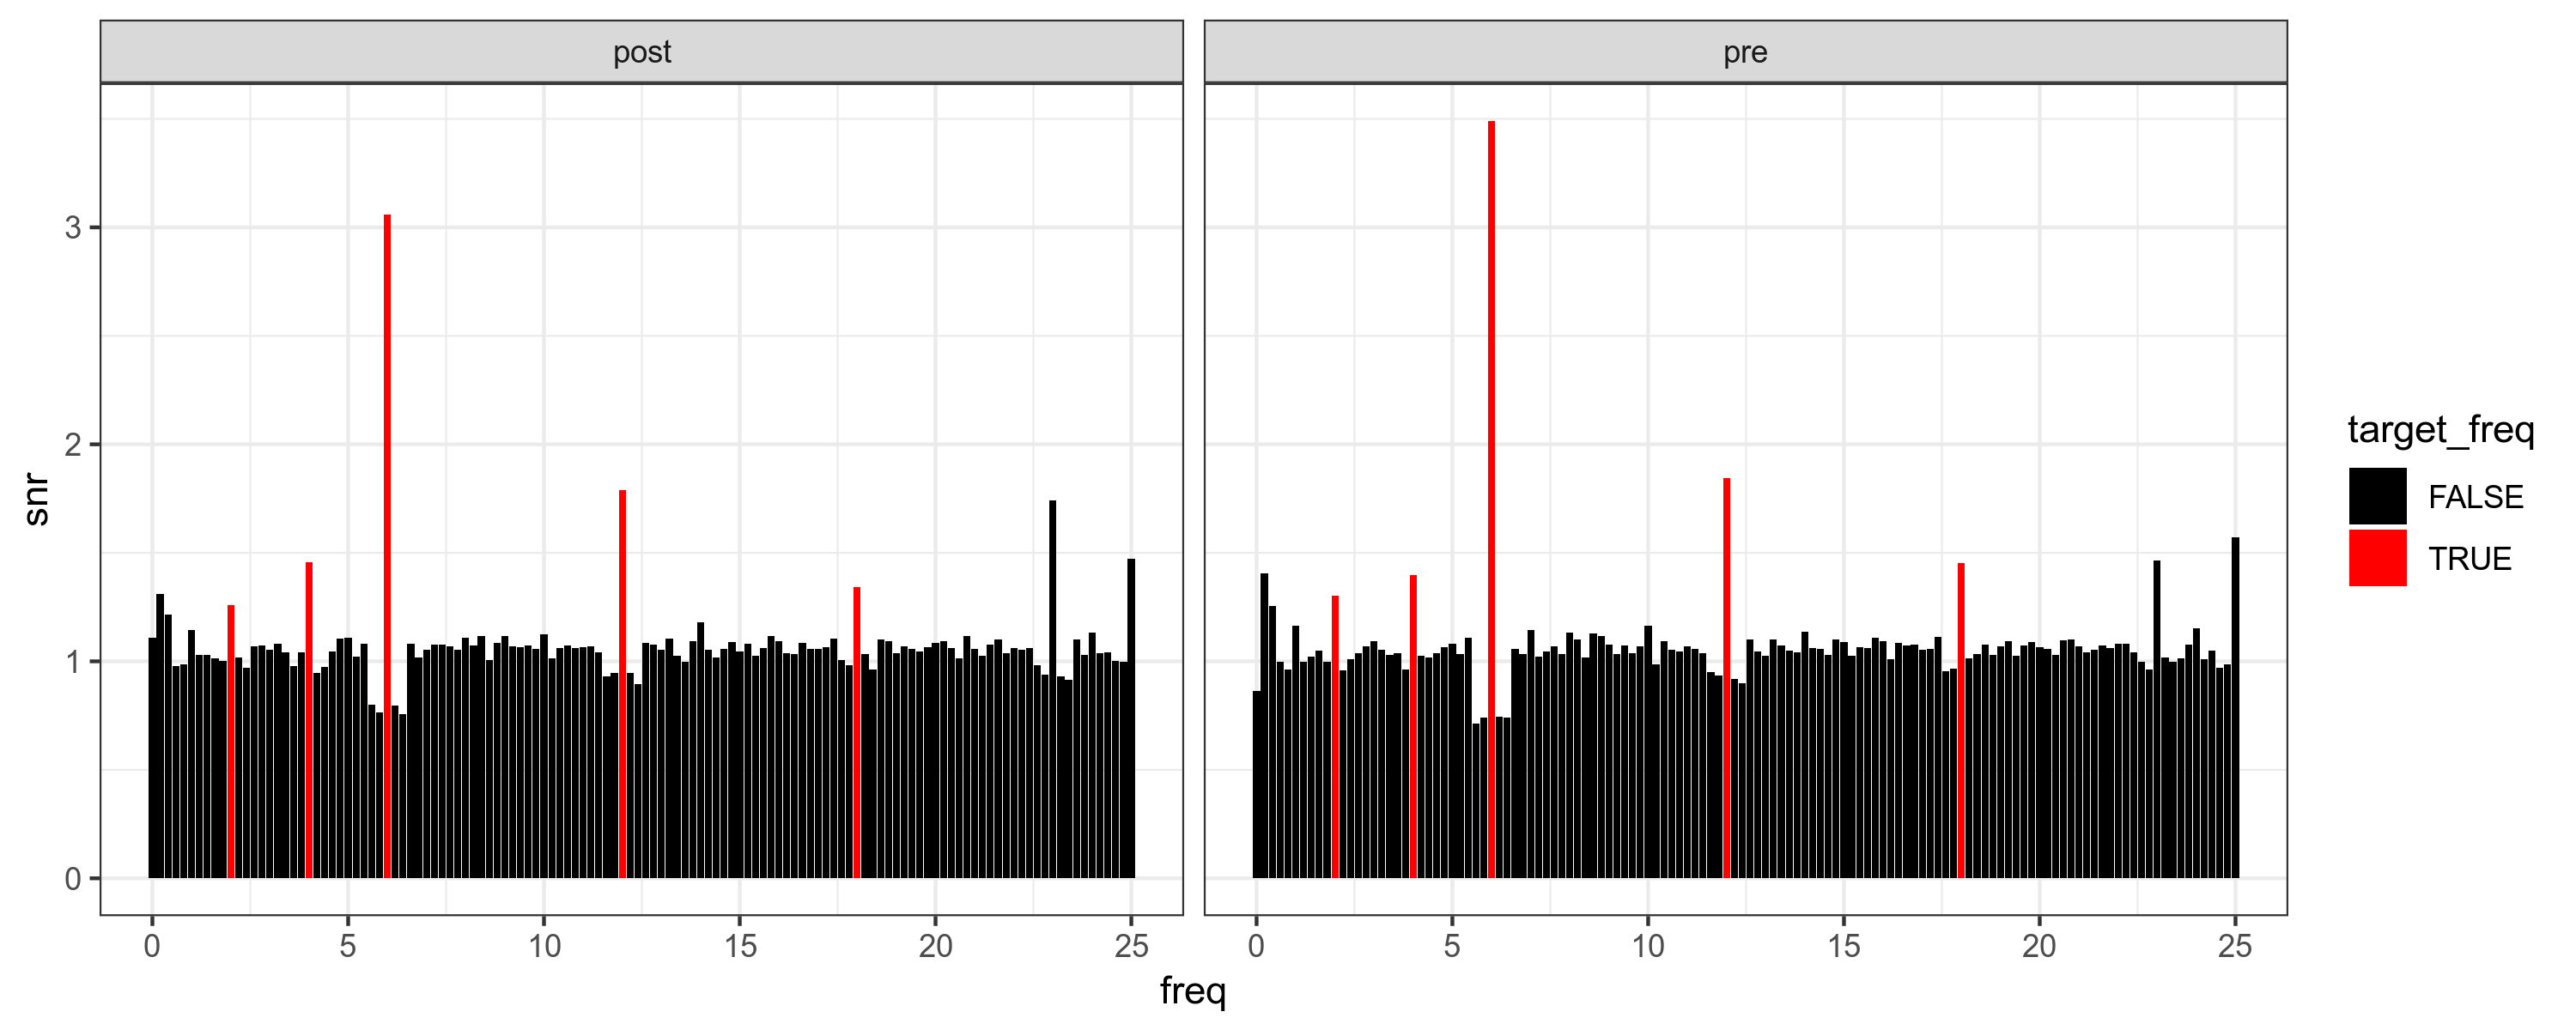

In [9]:
spectrum %>%
    ggplot(aes(x=freq, y=snr, fill=target_freq)) +
    facet_grid(. ~ timepoint) +
    geom_bar(stat="identity") +
    scale_fill_manual(values=c("black", "red")) +
    theme_bw()

That spike at 23 Hz (which is bigger in the post-intervention data) is a bit of a mystery.

## Make a tvalue-based ROI using pre-intervention 2 Hz or 4 Hz response
Next we'll compute an uncorrected t-statistic (across subjects, at each vertex) and use it as a mask to define an ROI. We'll do it separately for both 2 Hz and 4 Hz responses, filter on t-values greater than 4, and use that as our ROI for comparing the 2 Hz / 4 Hz response in our cohorts.

### Compute t-statistic
First we compute an (uncorrected) t-test of "signal bin" vs "mean of adjacent noise bins". This will yield a new dataframe with the t-test results.

In [10]:
# compute signal-vs-noise uncorrected t-test
all_data %>%
    filter(freq %in% c(2, 4), timepoint == "pre") %>%
    group_by(freq, hemi, vertex) %>%
    do(broom::tidy(t.test(.$amplitude, .$noise, paired=TRUE))) %>%
    rename(tval=statistic, df=parameter) ->
    tvals

### Merge
Now we merge the t-values back into the main dataframe, so we can use them to filter the data. Note that these t-values were computed *across subjects* as a way of defining an ROI, so joining based only on `freq`, `hemi` and `vertex` (and not `subject`) is correct here.

In [11]:
# merge t-values back into main dataframe
all_data %>%
    right_join(tvals, by=c("freq", "hemi", "vertex")) ->
    all_data

### Reduce data

Now that we have the t-values, we'll filter the data to only include our ROI vertices and the frequency we care about, and average across vertices to get a mean activation within the ROI. We'll do separate ROIs for each hemisphere.

In [12]:
all_data %>%
    filter(tval >= 4) %>%
    group_by(subject, timepoint, intervention, pretest, hemi, freq) %>%
    summarise_at(c("amplitude", "noise", "snr"), mean) %>%
    ungroup() ->
    tval_roi_data

print(tval_roi_data)

# A tibble: 384 x 9
   subject   timepoint intervention pretest hemi   freq amplitude noise   snr
   <chr>     <chr>     <chr>        <chr>   <chr> <dbl>     <dbl> <dbl> <dbl>
 1 prek_1103 post      language     lower   lh        2      34.6  32.8  1.06
 2 prek_1103 post      language     lower   lh        4      39.7  22.4  1.92
 3 prek_1103 post      language     lower   rh        2      50.6  33.3  1.58
 4 prek_1103 post      language     lower   rh        4      29.0  22.2  1.40
 5 prek_1103 pre       language     lower   lh        2      50.0  24.9  2.11
 6 prek_1103 pre       language     lower   lh        4      50.3  21.4  2.68
 7 prek_1103 pre       language     lower   rh        2      58.6  21.2  2.93
 8 prek_1103 pre       language     lower   rh        4      47.0  23.4  2.16
 9 prek_1110 post      language     upper   lh        2      33.4  19.3  1.74
10 prek_1110 post      language     upper   lh        4      44.1  22.0  2.09
# … with 374 more rows


Now we save the preprocessing work, so we don't have to do it every time:

In [13]:
save(tval_roi_data, file="processed_data_with_tvals.RData")

## Load SNR-based ROI labels

These are lists of vertices stored in YAML files, and are based on SNR thresholds between 1.5 (generous) and 2.5 (stringent) after pooling across all subjects and both pre- and post-camp measurements.

In [14]:
c(2, 4) -> roi_freqs
seq(1.5, 2.5, 0.1) -> snr_thresholds
list() -> snr_roi_data

for(freq_ in roi_freqs) {
    for(snr_ in snr_thresholds) {
        # load the YAML file
        str_interp("${freq_}_Hz-SNR_$[.1f]{snr_}.yaml") -> fname
        file.path("..", "ROIs", fname) -> verts_file
        yaml::read_yaml(verts_file) -> verts
        # average over vertices within this ROI label
        str_interp("${freq_}Hz_SNR_$[.1f]{snr_}") -> roi_name
        all_data %>%
            filter((vertex %in% verts$lh & hemi == "lh") | 
                   (vertex %in% verts$rh & hemi == "rh")) %>%
            group_by(subject, timepoint, intervention, pretest, hemi, freq) %>%
            summarise_at(c("amplitude", "noise", "snr"), mean) %>%
            ungroup() ->
            snr_roi_data[[roi_name]]
    }
}
# remove empty ROIs
snr_roi_data[sapply(snr_roi_data, function(x) nrow(x) > 0)] -> snr_roi_data

Now we save the preprocessing work, so we don't have to do it every time:

In [15]:
save(snr_roi_data, file="processed_data_with_SNR_based_labels.RData")

## Start here if skipping the preprocessing section

In [16]:
rm(all_data)  # free up memory; comment out if loading

# load("processed_data_with_tvals.RData")  # loads tval_roi_data
# load("processed_data_with_SNR_based_labels.RData")  # loads snr_roi_data

In [17]:
# massage the tvalue tibble to have the right columns for successful bind_rows
tval_roi_data %>% group_by(freq) -> tval_roi_data
tval_roi_data %>% group_keys() %>% pull() %>% str_c("Hz_tval_4.0") -> names
tval_roi_data %>% group_split(.keep=TRUE) %>%setNames(names) -> tval_list
# combine the data from the two different ROI definitions. Also pivot so that
# amplitude and SNR measures are in the same column, for easier group_by
bind_rows(c(snr_roi_data, tval_list), .id="roi_type") %>%
    tidyr::pivot_longer(cols=c(amplitude, snr), names_to="measure", values_to="value") ->
    roi_data

print(roi_data)

# A tibble: 13,824 x 10
   roi_type subject timepoint intervention pretest hemi   freq noise measure
   <chr>    <chr>   <chr>     <chr>        <chr>   <chr> <dbl> <dbl> <chr>  
 1 2Hz_SNR… prek_1… post      language     lower   lh        2  32.4 amplit…
 2 2Hz_SNR… prek_1… post      language     lower   lh        2  32.4 snr    
 3 2Hz_SNR… prek_1… post      language     lower   lh        4  22.4 amplit…
 4 2Hz_SNR… prek_1… post      language     lower   lh        4  22.4 snr    
 5 2Hz_SNR… prek_1… post      language     lower   rh        2  36.9 amplit…
 6 2Hz_SNR… prek_1… post      language     lower   rh        2  36.9 snr    
 7 2Hz_SNR… prek_1… post      language     lower   rh        4  22.5 amplit…
 8 2Hz_SNR… prek_1… post      language     lower   rh        4  22.5 snr    
 9 2Hz_SNR… prek_1… pre       language     lower   lh        2  24.1 amplit…
10 2Hz_SNR… prek_1… pre       language     lower   lh        2  24.1 snr    
# … with 13,814 more rows, and 1 more variable: valu

## Testing the main hypotheses

Now that we have our ROI data, let's test our hypotheses. We'll do it separately for each ROI definition and for each hemisphere.

### t-test of pre-intervention letter awareness

First we'll compare the two pretest groups (median split on the pre-intervention letter awareness test). We'll compute them all but only display tests with p-values < 0.25.

In [18]:
roi_data %>%
    filter(timepoint == "pre") %>%
    group_by(roi_type, hemi, freq, measure) %>%
    do(broom::tidy(t.test(value ~ pretest, data=.))) %>%
    rename(tval=statistic, df=parameter) ->
    pretest_tvals

pretest_tvals %>% filter(p.value < 0.1) %>% arrange(p.value)

roi_type,hemi,freq,measure,estimate,estimate1,estimate2,tval,p.value,df,conf.low,conf.high,method,alternative
<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
4Hz_SNR_2.5,rh,2,amplitude,18.3545120,60.307890,41.953378,2.183960,0.03706851,29.45578,1.1774714,35.5315527,Welch Two Sample t-test,two.sided
4Hz_SNR_2.4,rh,2,amplitude,17.4078593,59.668155,42.260296,2.103265,0.04388442,30.17663,0.5089590,34.3067595,Welch Two Sample t-test,two.sided
2Hz_SNR_1.9,rh,2,amplitude,17.4478486,59.969197,42.521348,2.030800,0.05137653,29.49089,-0.1112801,35.0069772,Welch Two Sample t-test,two.sided
2Hz_SNR_2.0,rh,2,amplitude,18.9299744,61.759039,42.829065,1.973576,0.05817753,28.55429,-0.7005937,38.5605425,Welch Two Sample t-test,two.sided
4Hz_SNR_2.1,rh,2,amplitude,14.2716607,56.640054,42.368393,1.912605,0.06468194,32.36758,-0.9209587,29.4642802,Welch Two Sample t-test,two.sided
4Hz_SNR_2.3,rh,2,amplitude,15.7446601,58.351587,42.606927,1.913524,0.06500205,30.84308,-1.0401186,32.5294388,Welch Two Sample t-test,two.sided
2Hz_SNR_1.7,rh,2,amplitude,13.0801026,55.512589,42.432486,1.899220,0.06627895,33.10343,-0.9301289,27.0903342,Welch Two Sample t-test,two.sided
4Hz_SNR_2.2,rh,2,amplitude,15.0368588,57.519972,42.483113,1.901615,0.06633388,31.73296,-1.0753317,31.1490492,Welch Two Sample t-test,two.sided
2Hz_SNR_1.5,rh,2,amplitude,11.5266611,52.641374,41.114713,1.887595,0.06775984,33.53386,-0.8896612,23.9429834,Welch Two Sample t-test,two.sided


Looks like there are some pre-test group differences detectable if the SNR is based on 4Hz response and we analyze raw amplitudes in the 2 Hz bin (p-value is `0.037` or `0.044` depending on SNR threshold used to make the ROI).  Interestingly, the groups are apparently *more similar* when comparing SNR than when comparing raw amplitude (the smallest p-value when analyzing SNR is `0.097`).

### t-test of intervention effect

For the intervention effect, what we care about is *change* in activation pre-versus-post intervention, so we'll need to do a `post - pre` subtraction. 

In [19]:
roi_data %>%
    tidyr::pivot_wider(names_from=timepoint, values_from=value, id_cols=c(subject, intervention, roi_type, hemi, freq, measure)) %>%
    mutate(post_minus_pre=post - pre) %>%
    group_by(roi_type, hemi, freq, measure) %>%
    do(broom::tidy(t.test(post_minus_pre ~ intervention, data=.))) %>%
    rename(tval=statistic, df=parameter) ->
    intervention_tvals

intervention_tvals %>% filter(p.value < 0.1) %>% arrange(p.value)

roi_type,hemi,freq,measure,estimate,estimate1,estimate2,tval,p.value,df,conf.low,conf.high,method,alternative
<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
4Hz_SNR_1.5,rh,2,amplitude,-18.0381238,-11.8178217,6.22030208,-2.984085,0.004715743,42.17239,-30.2354967,-5.840750903,Welch Two Sample t-test,two.sided
4Hz_SNR_1.5,rh,2,snr,-0.3713610,-0.2580768,0.11328417,-2.511401,0.015767623,44.03325,-0.6693671,-0.073354841,Welch Two Sample t-test,two.sided
4Hz_SNR_1.6,rh,2,amplitude,-14.4267088,-9.0368703,5.38983850,-2.405571,0.020531968,42.89365,-26.5220989,-2.331318822,Welch Two Sample t-test,two.sided
4Hz_SNR_1.5,lh,2,amplitude,-14.0579790,-7.6330888,6.42489016,-2.338756,0.023754979,45.93334,-26.1577263,-1.958231716,Welch Two Sample t-test,two.sided
4Hz_SNR_1.6,lh,2,amplitude,-12.5437304,-6.6681793,5.87555110,-2.148617,0.037047276,45.28680,-24.3001072,-0.787353473,Welch Two Sample t-test,two.sided
2Hz_tval_4.0,rh,2,amplitude,-13.1134947,-9.2536702,3.85982452,-2.150795,0.037214015,42.57002,-25.4129534,-0.814035961,Welch Two Sample t-test,two.sided
2Hz_SNR_1.5,rh,2,amplitude,-11.6668608,-7.0489551,4.61790571,-2.008235,0.051103007,41.83798,-23.3922730,0.058551376,Welch Two Sample t-test,two.sided
4Hz_SNR_1.6,rh,2,snr,-0.3160058,-0.2262764,0.08972933,-1.982280,0.053748435,43.76561,-0.6373348,0.005323331,Welch Two Sample t-test,two.sided
4Hz_SNR_1.5,lh,2,snr,-0.2332567,-0.1594370,0.07381971,-1.906852,0.062800423,45.97210,-0.4794892,0.012975849,Welch Two Sample t-test,two.sided


Looks like the intervention effect is significant for some choices of ROI. The best choice appears to be the `4Hz_SNR_1.5` ROI definition to compare raw signal amplitude in the 2 Hz bin (p-values `0.005` for right hemi and `0.024` for left hemi).

# Mixed model of intervention effect

Next let's see what the intervention effect looks like as a mixed model.

In [20]:
# create factor variables and set contrasts
dev_contrast <- function(x, ...) {
    x <- factor(x, ...)
    contrasts(x) <- contr.sum
    contrasts(x) <- contrasts(x) / 2
    colnames(contrasts(x)) <- paste0("_", levels(x)[-length(levels(x))])
    x
}

roi_data %>%
    # make predictors with sensible factor coding
    mutate(tpt=dev_contrast(timepoint, levels=c("pre", "post")),
           grp=dev_contrast(intervention, levels=c("language", "letter"))) %>%
    filter(roi_type=="4Hz_SNR_1.5") %>%
    group_by(roi_type, hemi, freq, measure) ->
    grouped_data

# WARNING: there are 19 ROIs defined in `grouped_data`, each evaluated for
# 2 bin frequencies and 2 measures (amplitude/SNR). If you remove the filter
# from the above pipeline it will run them all, but it will take quite a while
# (hours maybe, but not days).

In [21]:
# there is no tidy option for afex::mixed objects, not even broom.mixed::tidy,
# so we do group_split and lapply. Also this cell generates a **TON** of output
# and the %%capture cell magic doesn't work in R notebooks apparently, so get
# ready to scroll a lot.

grouped_data %>%
    group_keys() %>%
    transmute(name=str_c(roi_type, hemi, freq, measure, sep="_")) %>%
    pull() ->
    names

grouped_data %>%
    group_split() %>%
    lapply(function(data_) afex::mixed(value ~ tpt * grp + (1|subject),
                                       data=data_, method="PB", REML=FALSE,
                                       check_contrasts=FALSE)) %>%
    setNames(names) ->
    models

Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 



Fitting 4 (g)lmer() models:
[...

boundary (singular) fit: see ?isSingular



.]
Obtaining 3 p-values:
[

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSi

.

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSi

.

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSi

.]
Fitting 4 (g)lmer() models:
[....]
Obtaining 3 p-values:
[..

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



.]
Fitting 4 (g)lmer() models:
[....]
Obtaining 3 p-values:
[

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSi

.

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



.

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



.]
Fitting 4 (g)lmer() models:
[....]
Obtaining 3 p-values:
[.

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



..]
Fitting 4 (g)lmer() models:
[....]
Obtaining 3 p-values:
[

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSi

.

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



.

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSi

.]
Fitting 4 (g)lmer() models:
[....]
Obtaining 3 p-values:
[

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSi

.

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



.

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSi

.]
Fitting 4 (g)lmer() models:
[....]
Obtaining 3 p-values:
[...]
Fitting 4 (g)lmer() models:
[....]
Obtaining 3 p-values:
[

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



.

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



.

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



.]


Now we'll pull out the p-values from the models we ran, to get a sense of which ROIs / measures were useful for separating the groups.

In [22]:
models %>%
    sapply(function(x) {
        x[["tests"]] %>% sapply(function(y) y[["test"]][["PBtest", "p.value"]])
        }) %>%
    t() %>%
    as.data.frame() %>%
    tibble::rownames_to_column("roi") ->
    pvals
        
pvals %>% filter(tpt < 0.05 | grp < 0.05 | `tpt:grp` < 0.05)

roi,tpt,grp,tpt:grp
<chr>,<dbl>,<dbl>,<dbl>
4Hz_SNR_1.5_lh_2_amplitude,0.8661339,0.32667333,0.017982018
4Hz_SNR_1.5_lh_2_snr,0.5144855,0.60139860,0.046953047
4Hz_SNR_1.5_lh_4_amplitude,0.6623377,0.02397602,0.356643357
4Hz_SNR_1.5_rh_2_amplitude,0.3566434,0.22277722,0.005994006
4Hz_SNR_1.5_rh_2_snr,0.3416583,0.49850150,0.015984016


So it looks like our chosen ROI of `4Hz_SNR_1.5` does exhibit differences in both left and right hemispheres in the raw amplitude in 2 Hz bins. Let's see the full model summaries:

In [23]:
summary(models[["4Hz_SNR_1.5_lh_2_amplitude"]])
cat("\n------------------------------------------------------------------\n\n")
summary(models[["4Hz_SNR_1.5_rh_2_amplitude"]])

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: value ~ tpt * grp + (1 | subject)
   Data: data

     AIC      BIC   logLik deviance df.resid 
   801.4    816.8   -394.7    789.4       90 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6639 -0.5892 -0.1696  0.3938  4.0356 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept)  10.64    3.262  
 Residual             207.75   14.414  
Number of obs: 96, groups:  subject, 48

Fixed effects:
                     Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)           42.9300     1.5446 48.0000  27.793   <2e-16 ***
tpt_pre                0.6041     2.9422 48.0000   0.205   0.8382    
grp_language           3.0416     3.0892 48.0000   0.985   0.3298    
tpt_pre:grp_language  14.0580     5.8843 48.0000   2.389   0.0209 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
     


------------------------------------------------------------------



Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: value ~ tpt * grp + (1 | subject)
   Data: data

     AIC      BIC   logLik deviance df.resid 
   827.5    842.9   -407.7    815.5       90 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4257 -0.5484 -0.1184  0.3410  5.7821 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept)  89.86    9.48   
 Residual             210.10   14.49   
Number of obs: 96, groups:  subject, 48

Fixed effects:
                     Estimate Std. Error     df t value Pr(>|t|)    
(Intercept)            44.160      2.015 48.000  21.914  < 2e-16 ***
tpt_pre                 2.799      2.959 48.000   0.946  0.34892    
grp_language            5.280      4.030 48.000   1.310  0.19644    
tpt_pre:grp_language   18.038      5.918 48.000   3.048  0.00374 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          

Note that the model summaries show p-values estimated by Satterthwaite's method; you can see them side-by-side with the bootstrapped p-values below:

In [24]:
models[["4Hz_SNR_1.5_lh_2_amplitude"]]$tests

$tpt
Parametric bootstrap test; time: 14.34 sec; samples: 1000 extremes: 866;
large : value ~ tpt * grp + (1 | subject)
small : value ~ 0 + m.matrix[, -2L] + (1 | subject)
         stat df p.value
LRT    0.0421  1  0.8374
PBtest 0.0421     0.8661

$grp
Parametric bootstrap test; time: 14.29 sec; samples: 1000 extremes: 326;
large : value ~ tpt * grp + (1 | subject)
small : value ~ 0 + m.matrix[, -3L] + (1 | subject)
         stat df p.value
LRT    0.9597  1  0.3272
PBtest 0.9597     0.3267

$`tpt:grp`
Parametric bootstrap test; time: 14.62 sec; samples: 1000 extremes: 17;
large : value ~ tpt * grp + (1 | subject)
small : value ~ 0 + m.matrix[, -4L] + (1 | subject)
         stat df p.value  
LRT    5.3956  1 0.02019 *
PBtest 5.3956    0.01798 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# More detailed regressions

Here we explore the relationship between our ROI data and the various pre-test variables / dimensions.

### Load and clean behavioral metadata

First let's load the behavioral scores. We'll clean up a few columns and drop ones we don't need.

In [25]:
# load metadata
readr::cols(event="-", group="c", visit="c", .default="i") -> col_types
readr::read_csv(file.path("..", "behavioral", "preK_InterventionData.csv"),
                col_types=col_types) %>%
    # rename/transform variables
    rename(timepoint=visit) %>%
    mutate(subject=str_c("prek_", subID),
           intervention=str_to_lower(group)) %>%
    # reorder columns and drop unwanted columns
    select(subject, timepoint, intervention, everything(), -subID, -group) ->
    metadata

print(metadata)

Warning message:
“3 parsing failures.
row               col   expected actual                                      file
 11 PhonemeSegmenting an integer    NaN '../behavioral/preK_InterventionData.csv'
 13 PhonemeSegmenting an integer    NaN '../behavioral/preK_InterventionData.csv'
 90 Retell            an integer    NaN '../behavioral/preK_InterventionData.csv'
”


# A tibble: 96 x 10
   subject timepoint intervention AlphabetKnowled… Decoding PhonemeMatching
   <chr>   <chr>     <chr>                   <int>    <int>           <int>
 1 prek_1… pre       language                   49        0               7
 2 prek_1… post      language                   59        0               8
 3 prek_1… pre       language                   90        4              12
 4 prek_1… post      language                   93        0              12
 5 prek_1… pre       letter                     23        0              12
 6 prek_1… post      letter                     36        0              14
 7 prek_1… pre       language                   31        0               7
 8 prek_1… post      language                   34        0               8
 9 prek_1… pre       language                   82        0              15
10 prek_1… post      language                   89        5               8
# … with 86 more rows, and 4 more variables: PhonemeSegmenting <int>

### Merge brain data and metadata

Now we'll join our brain data and metadata.

In [26]:
roi_data %>%
    left_join(metadata, by=c("subject", "timepoint", "intervention")) ->
    roi_data

### Sample scatterplot

Let's take a look now at the relationship between the pre-test variables and the average 2 Hz response.

In [27]:
print(roi_data)

# A tibble: 13,824 x 17
   roi_type subject timepoint intervention pretest hemi   freq noise measure
   <chr>    <chr>   <chr>     <chr>        <chr>   <chr> <dbl> <dbl> <chr>  
 1 2Hz_SNR… prek_1… post      language     lower   lh        2  32.4 amplit…
 2 2Hz_SNR… prek_1… post      language     lower   lh        2  32.4 snr    
 3 2Hz_SNR… prek_1… post      language     lower   lh        4  22.4 amplit…
 4 2Hz_SNR… prek_1… post      language     lower   lh        4  22.4 snr    
 5 2Hz_SNR… prek_1… post      language     lower   rh        2  36.9 amplit…
 6 2Hz_SNR… prek_1… post      language     lower   rh        2  36.9 snr    
 7 2Hz_SNR… prek_1… post      language     lower   rh        4  22.5 amplit…
 8 2Hz_SNR… prek_1… post      language     lower   rh        4  22.5 snr    
 9 2Hz_SNR… prek_1… pre       language     lower   lh        2  24.1 amplit…
10 2Hz_SNR… prek_1… pre       language     lower   lh        2  24.1 snr    
# … with 13,814 more rows, and 8 more variables: val

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



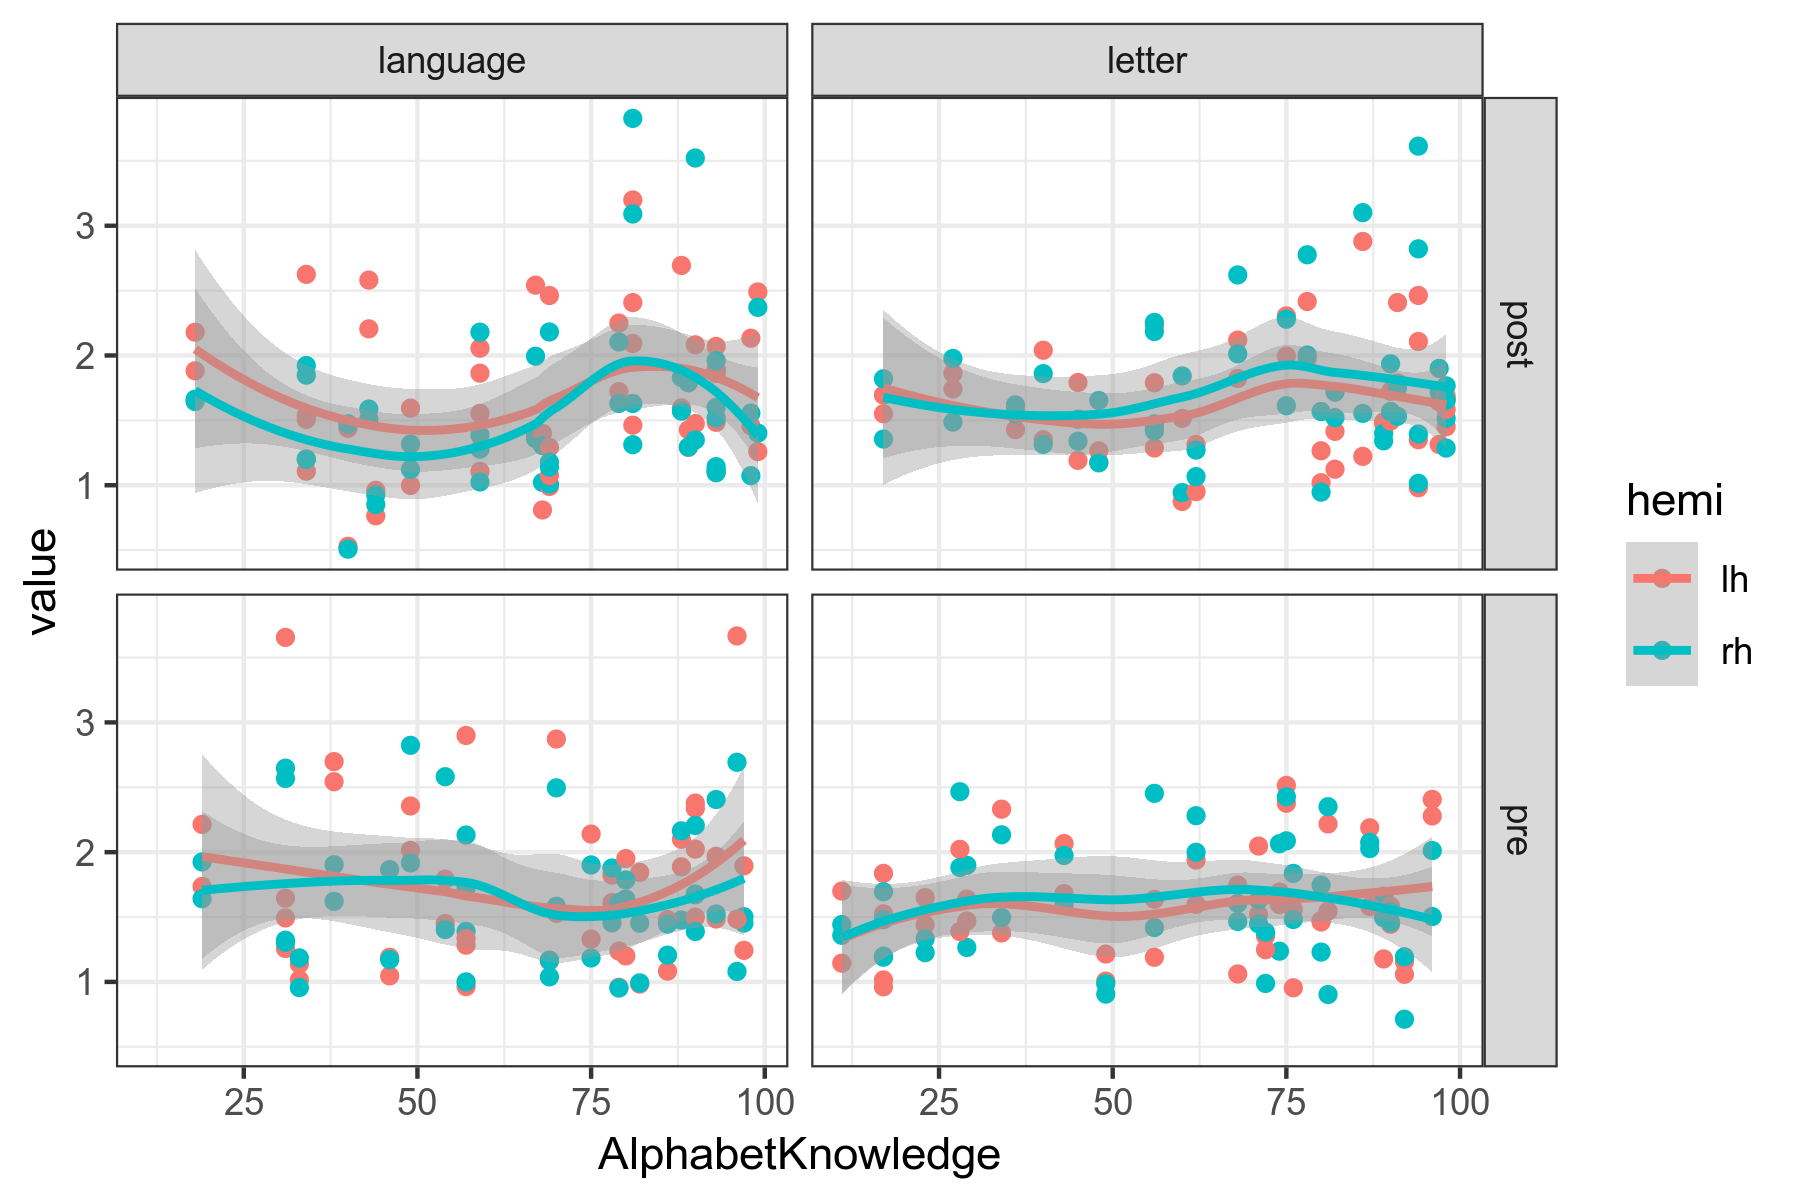

In [28]:
options(repr.plot.width=6)

roi_data %>%
    # select ROI type (tval, 2Hz_SNR_1.7, 4Hz_SNR_2.1, etc)
    filter(roi_type == "4Hz_SNR_1.5",measure=="snr") %>%
    # select x (AlphabetKnowledge, PhonemeMatching, etc) and y (snr, amplitude)
    ggplot(aes(x=AlphabetKnowledge, y=value, colour=hemi)) + 
    facet_grid(timepoint ~ intervention) + 
    geom_point() +
    geom_smooth() +
    theme_bw()